In [1]:
import pandas as pd
import ast
import io
import numpy as np
import tensorflow as tf
import tqdm
import plotly.express as px
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dot, Embedding, Flatten

In [2]:
# Global Variables
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE
WINDOW_SIZE = 10
NUM_NS = 3

## Data Extraction and Genre Indexing

Typically, tensorflow's TextVectorization layer would be used to convert a corpus of words into indexes. However, because I am vectorizing genres--which are sometimes multiple words--I will be manually implementing this functionality below.

The lists of genres will be extracted from `data/data_w_genres.csv`, as this gives a set of genres per artist; this is the only dataset that has lists of genres as an input rather than just one (or no) genres listed. These sets of genres are important as they show which genres generally "keep the company" of other genres (e.g. hard rock may often appear with classic rock).

In [3]:
# Extracting a Series of lists of genres to form a corpus

data = pd.read_csv('data/data_w_genres.csv')
corpus = data['genres']
corpus = corpus[corpus != '[]']
corpus = corpus.apply(ast.literal_eval)
corpus.head()

0                                          [show tunes]
8                          [comedy rock, comic, parody]
9     [emo rap, florida rap, sad rap, underground hi...
10                                [dark trap, meme rap]
12    [asian american hip hop, cali rap, west coast ...
Name: genres, dtype: object

In [4]:
genre_sequences = list(corpus)
flat_corpus = [item for sublist in genre_sequences for item in sublist] # list of every occurance of every genre
genres = set(flat_corpus) # set of all genres present in the corpus

To improve the model's accuracy, I'm electing to remove genres which do not appear often in the dataset. The cells below walk through a quick frequency analysis.

In [5]:
df = pd.DataFrame(flat_corpus)
frequency = pd.DataFrame(df.value_counts())
frequency.columns = ['occurances']
frequency = frequency.reset_index()
frequency.columns = ['genre', 'occurances']
frequency.head()

,genre,occurances
0,rock,611
1,pop,593
2,dance pop,572
3,rap,516
4,hip hop,507


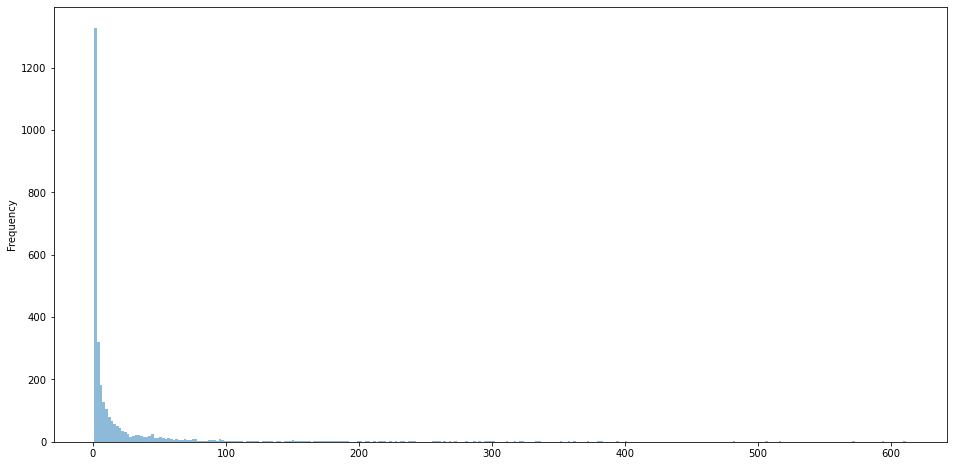

In [6]:
frequency['occurances'].plot.hist(bins=300, alpha=0.5, figsize=(16,8));

Looks like the majority of these genres only appear less than 5 times within the corpus. I don't want to filter out too many genres, but my intuition says to drop genres with fewer than 25 occurances.

As seen below, if I use 25 as a threshold, this will leave me with only 18% of the original genres, but this is still 542 of the more common genres. I will see how this impacts my resulting corpus (if any lists are now empty).

In [7]:
mask = frequency['occurances'] > 25
trim_freq = frequency[mask]
print("percent remaining: " + str(100*len(trim_freq)/len(frequency)))
print("length of dataset: "+ str(len(trim_freq)))

percent remaining: 18.23687752355316
length of dataset: 542


## Genre Indexing...

In [8]:
# Generating manual indexes for each genre

genre2int = {}

genre2int[''] = 0 # manually adding padding token
for i,genre in enumerate(trim_freq['genre']):
    genre2int[genre] = i+1 # i+1 is required because the value `0` will be used for padding

# Test
genre2int['funk'] # index = 16

16

In [9]:
# Generating datastructure for easily reverse lookup of indexes

int2genre = {index: genre for genre, index in genre2int.items()}

# Test
int2genre[16] # genre = 'funk'

'funk'

In [10]:
# Saving 'vocabulary size', the quantity of unique genres left after filtering
vocab_size = len(genre2int)
vocab_size

543

In [11]:
# converting squences of genres to sequences of genre indexes

genre_int_sequences = []
for sequence in genre_sequences:
    genre_int_sequences.append([genre2int[genre] for genre in sequence if genre in list(trim_freq['genre'])])
    
genre_int_sequences = [sequence for sequence in genre_int_sequences if sequence != []] # filter out any empty lists
genre_int_sequences[:5]

[[55], [144], [142, 199, 48, 138], [238, 313], [198, 250]]

In [12]:
print(f"Data set size is now {len(genre_int_sequences)} instead of original size of {len(corpus)}. This is {100*len(genre_int_sequences)/len(corpus)}% of the original data")

Data set size is now 16029 instead of original size of 18823. This is 85.1564575253679% of the original data


Although over 80% of the genres were removed, 85% of the sequences still remain. I am content with these results and will keep the frequency filter of 25 occurances or more.

## Padding 

Now we have `genre_int_seqeunces`, a list of lists where the sublists represent a sequence of genres in index form. However, for the word2vec model, we need _padded lists_; this means, regardless of how many genres are listed, each sequence will be the same length filled in with `0`s when appropriate. Normally this is handled in the TextVectorization class, however, because I am using genres (which are sometimes comprised of multiple words) instead of a strict one-word vocabulary, I am going to manually create `padded_int_sequences`, the required numpy array of genre indexes and pad these lists, using the `pad_sequences` method in the [preprocessing library](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences#used-in-the-notebooks).

In [13]:
padded_int_sequences = pad_sequences(
    genre_int_sequences, 
    padding="post",
    value=0)

# Test

for seq in padded_int_sequences[:3]:
    print(f"{seq} => {[int2genre[i] for i in seq]}")

[55  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] => ['show tunes', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] => ['comic', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[142 199  48 138   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] => ['emo rap', 'sad rap', 'underground hip hop', 'vapor trap', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [14]:
type(padded_int_sequences)

numpy.ndarray

The three sequences above show the `0`s that pad the sequence to ensure each sequence is 20 elements long (the max number of genres listed in any given sequences).

## Generating Training Data with Skip-grams

Skip-grams are pairs of a target genre and a neighboring genre within a perscribed sampling window size. With this skip grams, we can make a list of target genres and their corresponding "contexts"; these contexts have both the true neighbor and false genres, so you also require a list of "labels" that specify which is a true neighbor for supervized training.

Note, within the `generate_training_data` function, a sampling table is first built. This is to account for more common genres which may be sampled more frequently.

In [15]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    '''
    Generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) 
    based on window size, number of negative samples and genre-options size.

    Args:
        - sequences: array of padded lists
        - window_size: int, how many "neighbors" to the left or right of the current word used for sampling
        - num_ns: int, the quantity of negative samples
        - vocab_size: int, the quantity of unique indexes in the corpus
        - seed: int, operation level seed
    Returns:
        - targets: list of genre targets
        - contexts: list of genre-samples around target genre (some true neighbors, others false)
        - labels: list of arrays denoting which context samples are true and which are negative
    '''

    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence, 
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples 
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=seed, 
                name="negative_sampling")
            
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            # Build context and label vectors (for one target word)
            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

Now I should be able to use this function to construct a list of targets, contexts, and labels.

In [16]:
targets, contexts, labels = generate_training_data(
    sequences=padded_int_sequences, 
    window_size=WINDOW_SIZE, 
    num_ns=NUM_NS, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 16029/16029 [00:01<00:00, 11389.15it/s]

15135 15135 15135


In [17]:
print(f"target  :", targets[0])
print(f"context :", contexts[0] )
print(f"label   :", labels[0] )

target  : 313
context : tf.Tensor(
[[238]
 [ 48]
 [  8]
 [160]], shape=(4, 1), dtype=int64)
label   : tf.Tensor([1 0 0 0], shape=(4,), dtype=int64)


## Configure the Dataset for Performance

We can put the lists of targets, contexts, and labels together in a formal TF dataset structure using `tf.data.Dataset` which is an object of `(target_word, context_word), (label)`.

[Batching](https://stackoverflow.com/questions/41175401/what-is-a-batch-in-tensorflow), in short, is a method of training on your data faster. `batch_size` is a hyperparameter and there is no "right" answer of what to use. Though, larger batch sizes may lead to overfitting. 

[Shuffling](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) a dataset allows for better randomization within batches, The dataset is filled into a buffer of size `Buffer_size` and replaces selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required. So in this case, I think the dataset size is 15043 elements.

BatchDataset shapes seem to follow example above, even without squeezing. Although, I did tweak my code by setting `drop_remainder` to False.

[Caching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) simply caches the elements of the dataset into memory. cached data persists across runs.

[Prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) allows for faster processing as later elements are prepared while current elements are being processed. Autotuning can be used to select the maximum number of elements that will be buffered when prefetching.

In [18]:
BATCH_SIZE = 512
BUFFER_SIZE = 15045
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=False)
print(dataset)

<BatchDataset shapes: (((None,), (None, 4, 1)), (None, 4)), types: ((tf.int32, tf.int64), tf.int64)>


In [19]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((None,), (None, 4, 1)), (None, 4)), types: ((tf.int32, tf.int64), tf.int64)>


## Word2Vec Model and Training

The Word2Vec model can be implemented as a classifier to distinguish between true context words from skip-grams and false context words obtained through negative sampling. You can perform a dot product between the *embeddings*, or the vectorized value, of target and context words to obtain predictions for labels and compute loss against true labels in the dataset.

This Word2Vec model class is comprised of:
* a `target_embedding` layer which looks up the embedding of the word as it appears as a target word.
* a `context_embedding` layer which looks up the embedding of the word as it appears as a context word.
* a `dots` layer which computes to dot product of the target and context embedding from a training pair
* a `flatten` layer

In [20]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=NUM_NS+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)

In [21]:
embedding_dim = 64 # specifies how many dimensions will be present in the vector
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# Method of vizualizing loss and metrics during training. More on this in later revisions
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [23]:
# Fitting the final model
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 1.3857 - accuracy: 0.3047WARNING:tensorflow:From C:\Users\nanai\anaconda3\envs\word2vec\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 0s 14ms/step - loss: 1.3834 - accuracy: 0.3975
Epoch 2/20
30/30 [==============================] - 0s 3ms/step - loss: 1.3688 - accuracy: 0.7580
Epoch 3/20
30/30 [==============================] - 0s 3ms/step - loss: 1.3336 - accuracy: 0.8534
Epoch 4/20
30/30 [==============================] - 0s 3ms/step - loss: 1.2588 - accuracy: 0.8613
Epoch 5/20
30/30 [==============================] - 0s 2ms/step - loss: 1.1406 - accuracy: 0.8536
Epoch 6/20
30/30 [==============================] - 0s 2ms/step - loss: 0.9988 - accuracy: 0.8529
Epoch 7/20
30/30 [===============

This model resulted in fairly good fits with embedding dimensions of 64. I experimented with fewer dimesions and even at 24 dimensions the model general achieves an accuracy of ~90%. I'm selecting 64 as these embeddings generally lead to more meaningful relations between genres.

## Extracting final genre vectors

Finally, I need to extract the weights calculated in the Word2Vec model. I'll map these weights to genres analyzed, as the represent the vectorized values of each genre.

In [24]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = list(genre2int.keys())

In [25]:
weights.shape # confirming qty of genres and embedding dimensions

(543, 64)

In [26]:
# Example of one of the weights / vectors
weights[542]

array([ 1.05009535e-02, -3.28996241e-01,  3.14803332e-01, -3.30599904e-01,
        2.03582540e-01,  1.98665857e-01,  6.01022132e-02, -2.06712544e-01,
       -1.62228987e-01, -1.15187332e-01,  3.52495849e-01,  4.21664640e-02,
       -1.14983000e-01,  3.21032315e-01,  2.54042059e-01, -2.65479386e-01,
       -1.36538818e-01,  3.90089065e-01,  2.39746854e-01,  3.49652886e-01,
        3.66764665e-01, -1.93446562e-01,  3.63179713e-01,  3.59331369e-01,
        2.96258837e-01, -2.52539843e-01,  6.49798214e-02, -2.18003258e-01,
       -1.68012694e-01, -2.76329696e-01, -5.46084680e-02, -8.75389948e-02,
       -2.94985592e-01,  2.79863000e-01, -1.57023191e-01, -2.81234860e-01,
       -1.14655268e-05, -3.34925383e-01, -3.26450408e-01,  1.87006727e-01,
        3.87621552e-01,  3.58506411e-01,  8.30801576e-02, -1.69880927e-01,
       -3.52208197e-01, -1.59003034e-01, -1.45288512e-01, -3.35467875e-01,
        4.99246195e-02, -5.58484644e-02, -1.84966952e-01,  8.48656371e-02,
        1.54510006e-01,  

In [27]:
vocab[542]

'ska revival'

In [28]:
# Saving the vectors and metadata to tsv's
out_v = io.open('fit_vectors/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('fit_vectors/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [61]:
# saving frequency data as well
frequency.to_csv('fit_vectors/frequency.csv')

## Resources

* [Word2Vec Documentation](https://www.tensorflow.org/tutorials/text/word2vec)
* [Visualizer](https://projector.tensorflow.org/)